In [1]:
import os 
import json
import FIDN
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION']='1'
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Use CPU

In [2]:
fpath = './all_304_fire_combine_all_feature_512_wind_precipitation_new.npy'

# Load Dataset
dataset = FIDN.dataset.load_dataset(fpath)
_, _, test_dataset = FIDN.dataset.split_dataset(dataset)
dataset = test_dataset

In [3]:
os.makedirs('./benchmark-result', exist_ok=True)
os.makedirs('./benchmark-result/fidn', exist_ok=True)
os.makedirs('./benchmark-result/ca', exist_ok=True)

## Helper

In [4]:
def read_ignition_to_binary(path, shape):
    # Change to gray scale and resize to shape
    ignition = Image.open(path).convert('L')
    ignition = ignition.resize(shape)
    ignition = ImageOps.invert(ignition)
    # Convert to range 0 ~ 255
    ignition = np.array(ignition)
    ignition[ignition > 0.] = 1.
    return ignition

In [5]:
def fire_reshape(img, shape):
    img = Image.fromarray(img).convert('L')
    img = img.resize(shape)
    img = np.array(img,dtype=np.int32)
    return img

In [6]:
def convert_binary_to_forest_array(img):
    # Convert to range 0 ~ 255
    img = np.array(img)
    img[img > 0] = 4.
    img[img <= 0] = 2.
    return img

In [7]:
def convert_forest_array_to_binary(img):
    # Convert to range 0 ~ 255
    img = np.array(img)
    img[img <= 2.] = 0.
    img[img > 2.] = 1.
    return img

In [8]:
def convert_512_fire_to_432(img, fire_info):
    """
    From 512 * 512 to 288 * 432
    """
    img = img[112:-112, 40:-40]
    origin_shape = img.shape

    border_x = int((432. * 30000 / fire_info['x_diff']) / 2)
    border_y = int((288. * 30000 / fire_info['y_diff']) / 2)
    
    img = Image.fromarray(img).resize((origin_shape[1] + 2 * border_x, 
                                       origin_shape[0] + 2 * border_y))
    img = np.array(img)
    img = img[border_y:-border_y,border_x:-border_x]
    img[img >= 0.2] = 1.
    img[img < 0.2] = 0.
    return img

In [9]:
def convert_432_to_512(img, fire_info):
    """
    From 288 * 432 to 512 * 512
    """
    border_x = int((432. * 30000 / fire_info['x_diff']) / 2)
    border_y = int((288. * 30000 / fire_info['y_diff']) / 2)
    
    img = np.pad(img,[(border_y, border_y), (border_x, border_x)],mode='constant')
    img = Image.fromarray(img).resize((432, 288))
    img = np.asarray(img)
    img = np.pad(img,[(112, 112),(40, 40)],mode='constant')
    return img

## Common

In [10]:
cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green', 'red'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds = [1.0, 2.03, 2.35, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42672\1114128114.py:12: UserWarning: Use the colorbar set_ticks() method instead.
  plt.xticks(ticks=[1.0, 2.03, 2.35, 3.5], labels=[


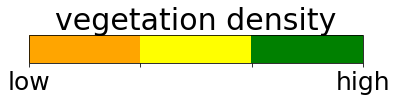

In [11]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds = [1.0, 2.03, 2.35, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')  # label='Vegetation density')
plt.xticks(ticks=[1.0, 2.03, 2.35, 3.5], labels=[
           'low', '', '', 'high'], fontsize=25)
plt.title("vegetation density", fontsize=30)
plt.show()

In [12]:
fire_list = ['Perry_2018_NAT', 'Ranch_2018_NAT', 'Rim_2018_NAT', 'River_2018_NAT', 'Roosevelt_2018_NAT',
             'Ryan_2018_NAT', 'Sharps_2018_NAT', 'Stone_2018_NAT', 'Whaleback_2018_NAT', 'Woolsey_2018_NAT',
             'Briceburg_2019_NAT', 'Camp_2019_NAT', 'Caples_2019_NAT', 'Easy_2019_NAT', 'Fishhawk_2019_NAT',
             'Jordan_2019_NAT', 'Kincade_2019_NAT', 'Lime_2019_NAT', 'Lincoln_2019_NAT', 'Middle_2019_NAT',
             'Neck_2019_NAT', 'Ranch_2019_NAT', 'South_2019_NAT', 'Springs_2019_NAT', 'Taboose_2019_NAT',
             'Thomas_2019_NAT', 'Tick_2019_NAT', 'Valley_2019_NAT', 'Walker_2019_NAT', 'Woodbury_2019_NAT',
             'Apple_2020_NAT']

In [13]:
# fire_index_list = [11,1,0,6,3,8,5]
fire_index_list=list(range(31))

## Fire Info

In [14]:
from pyproj import Geod
from shapely.geometry import Point, LineString, Polygon

In [15]:
def get_area_center(w, e, n, s):
    geod = Geod(ellps="WGS84")
    poly = Polygon([
        (e, s), (w, s),
        (w, n), (e, n)
    ])
    area , _= geod.geometry_area_perimeter(poly) 
    center = poly.centroid
    return abs(area / 1e6), center.x, center.y # km^2

In [16]:
fire_info_list = []
for fire_index in fire_index_list:
    fire_name = fire_list[fire_index]
    # Load Fire info
    with open(f"./CA/data/{fire_index}_info_{fire_name}.json", 'r') as load_f:
        fire_info = json.load(load_f)
        fire_info['name'], fire_info['year'], _ = str.split(fire_info['name'], sep='_')
        fire_info['area'],fire_info['longitude'],fire_info['latitude'] = get_area_center(fire_info['w'],fire_info['e'],fire_info['n'],fire_info['s'])
        fire_info_list.append(fire_info)
fire_info_pd = pd.DataFrame.from_records(fire_info_list,index='index')
fire_info_pd = fire_info_pd[['name', 'year', 'longitude', 'latitude','area','total_day',]]
fire_info_pd

name  year   longitude   latitude         area  total_day
index                                                                
0          Perry  2018 -119.491031  39.801780   453.124879          6
1          Ranch  2018 -122.779183  39.285022  3064.084890         48
2            Rim  2018 -120.029416  37.937320  1032.258635         19
3          River  2018 -123.025173  39.054263   404.532838         11
4      Roosevelt  2018 -110.398130  43.059765   595.324103         16
5           Ryan  2018 -106.606570  41.032865   299.136761         16
6         Sharps  2018 -114.051310  43.533553   437.609348          9
7          Stone  2018 -121.016703  41.426091   297.251141         16
8      Whaleback  2018 -120.827181  40.626714   116.837298          6
9        Woolsey  2018 -118.820925  34.126071   788.519410          9
10     Briceburg  2019 -119.932005  37.607277    34.473265          4
11          Camp  2019 -121.561828  39.749553  1178.527983         13
12        Caples  2019 -120.160562  38.706874    34.377302         11
13          Easy  2019 -118.828221  34.268267    15.365135         11
14      Fishhawk  2019 -109.851340  44.384064    95.269280          4
15        Jordan  2019 -118.307249  36.219804     3.837726          5
16       Kincade  2019 -122.773811  38.672823   630.938496          7
17          Lime  2019 -122.660945  41.865768    11.199017          4
18       Lincoln  2019 -116.072822  33.538324     2.224932          4
19        Middle  2019 -123.002851  40.883340     9.465201         10
20          Neck  2019 -113.138762  38.072315   129.172470          4
21         Ranch  2019 -122.629760  40.055905    17.516344          5
22         South  2019 -122.822864  40.117340    63.700019         10
23       Springs  2019 -118.884645  37.827422    14.333982          6
24       Taboose  2019 -118.357879  37.003309    33.549795          6
25        Thomas  2019 -119.219604  34.374895   714.753584         20
26          Tick  2019 -118.391202  34.449439    38.580229          4
27        Valley  2019 -122.659708  38.806648   164.523032          5
28        Walker  2019 -120.586400  40.091047   395.921774         13
29      Woodbury  2019 -111.178474  33.519331  1170.688593         21
30         Apple  2020 -116.864869  34.032035   227.186045         17

In [17]:
fire_info_pd.to_csv('./benchmark-result/fire_info.csv',float_format='%.2f')

## FIDN model

In [18]:
model_path = f'./models/fidn_1.0_fidn_epoch100_batchsize16.h5'
fidn_model = FIDN.evaluate.load_model(model_path)
fidn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                4)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 128, 128, 14  0          ['input_1[0][0]']                
 ingOpLambda)                   )                                                                 
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 512, 512, 3)  0          ['input_1[0][0]']                
 icingOpLambda)                                                                               

## FIDN Mertics

In [19]:
fidn_mertics = pd.DataFrame( {
        "index": [],
        "ssim": [],
        "psnr": [],
        "mse": [],
        "rrmse": [],
        "runtime": []
})

for fire_index in fire_index_list:
    fire_name = fire_list[fire_index]
    # Load Fire info
    with open(f"./CA/data/{fire_index}_info_{fire_name}.json", 'r') as load_f:
        fire_info = json.load(load_f)

    # Read Forest
    forest = Image.open(f'./CA/data/{fire_index}_canopy_{fire_name}.tif')
    forest = np.array(forest)
    forest[forest < -999.] = 0.
    forest = forest/np.max(forest)

    # Get Input Data and truth
    example = dataset[fire_index]
    frames = example[..., :-1]

    start = datetime.datetime.now()
    fidn_pred_binary_512 = fidn_model.predict(
            np.expand_dims(frames, axis=0), verbose=0)
    end = datetime.datetime.now()
    runtime = (end - start).total_seconds()

    truth_binary_512 = example[..., -1:]
    truth_binary_512 = truth_binary_512.astype(np.float32)

    fidn_ssim = FIDN.losses.ssim_metrics(
        np.expand_dims(truth_binary_512, axis=0).astype(np.float32),
        np.expand_dims(fidn_pred_binary_512, axis=0).astype(np.float32)
    ).numpy()

    fidn_psnr = FIDN.losses.psnr_metrics(
        np.expand_dims(truth_binary_512, axis=0).astype(np.float32),
        np.expand_dims(fidn_pred_binary_512, axis=0).astype(np.float32)
    ).numpy()

    fidn_mse = FIDN.losses.custom_mean_squared_error(
        np.expand_dims(truth_binary_512, axis=0).astype(np.float32),
        np.expand_dims(fidn_pred_binary_512, axis=0).astype(np.float32)
    ).numpy()

    fidn_rrmse = FIDN.losses.relative_root_mean_squared_error(
        np.expand_dims(truth_binary_512, axis=0).astype(np.float32),
        np.expand_dims(fidn_pred_binary_512, axis=0).astype(np.float32)
    ).numpy()
    fidn_mertics.loc[len(fidn_mertics.index)] = [fire_index, fidn_ssim, fidn_psnr, fidn_mse, fidn_rrmse, runtime]
    print(fire_index, fidn_ssim, fidn_psnr, fidn_mse, fidn_rrmse, runtime)
fidn_mertics[['index']] = fidn_mertics[['index']].astype(int)
fidn_mertics = fidn_mertics.set_index('index')


0 0.9710843 21.346622 0.007333944 0.60128605 4.121543
1 0.920221 14.363923 0.036610667 1.1633177 0.95403
2 0.94202423 16.472443 0.022529714 1.1205671 0.96487
3 0.9721915 21.989124 0.0063253907 0.5679112 0.91064
4 0.9578967 19.045313 0.012458586 0.8566646 0.962448
5 0.9711771 21.739437 0.0066997143 0.74311966 0.904266
6 0.9700963 20.253332 0.009433368 0.6335946 0.908154
7 0.9732944 20.80754 0.008303208 0.75720125 0.954678
8 0.984043 25.408665 0.0028782827 0.4968072 0.901159
9 0.94784915 16.429743 0.022752319 1.2580711 0.91167
10 0.9828286 22.270878 0.005928053 0.7339057 0.946253
11 0.9699216 23.157806 0.0048330273 0.36306956 0.900038
12 0.9836804 24.710323 0.0033803955 0.7239481 0.901178
13 0.97626513 20.58547 0.008738821 0.90741587 0.916466
14 0.9788829 23.92412 0.004051239 0.61184514 0.918563
15 0.9826234 21.599165 0.00691964 0.94796354 0.932319
16 0.95902073 17.37914 0.018284619 1.0965973 0.947574
17 0.9852282 22.490547 0.0056356653 0.8559848 0.919882
18 0.96583277 18.401196 0.014450

In [20]:
fidn_mertics.to_csv('./benchmark-result/densnet_metrics.csv',float_format='%.4f')

## CA Metrics

In [21]:
ca_mertics = pd.DataFrame( {
        "index": [],
        "ssim": [],
        "psnr": [],
        "mse": [],
        "rrmse": [],
        "runtime": []
})


for fire_index in fire_index_list:
    fire_name = fire_list[fire_index]
    # Load Fire info
    with open(f"./CA/data/{fire_index}_info_{fire_name}.json", 'r') as load_f:
        fire_info = json.load(load_f)
    
    # Load Runtime
    with open(f"./CA/result/time/{fire_index}_time_{fire_name}.json", 'r') as load_f:
        ca_runtime = json.load(load_f)['runtime']

    # Read Forest
    forest = Image.open(f'./CA/data/{fire_index}_canopy_{fire_name}.tif')
    forest = np.array(forest)
    forest[forest < -999.] = 0.
    forest = forest/np.max(forest)

    # Read CA predict fire
    ca_pred = np.load(f"./CA/result/{fire_index}_fire_range_{fire_name}_{fire_info['total_day']}.npy", 'r')
    ca_pred_binary = convert_forest_array_to_binary(ca_pred)
    
    # Read turth_fire
    truth_binary = read_ignition_to_binary(f'./CA/data/{fire_index}_ignition_{fire_name}_final.png',(forest.shape[1], forest.shape[0]))

    ca_pred_binary_512 = convert_432_to_512(ca_pred_binary, fire_info)
    truth_binary_512 = convert_432_to_512(truth_binary, fire_info)

    ca_ssim = FIDN.losses.ssim_metrics(
        np.expand_dims(truth_binary_512, axis=(0,-1)).astype(np.float32),
        np.expand_dims(ca_pred_binary_512, axis=(0,-1)).astype(np.float32)
    ).numpy()

    ca_psnr = FIDN.losses.psnr_metrics(
        np.expand_dims(truth_binary_512, axis=(0,-1)).astype(np.float32),
        np.expand_dims(ca_pred_binary_512, axis=(0,-1)).astype(np.float32)
    ).numpy()

    ca_mse = FIDN.losses.custom_mean_squared_error(
        np.expand_dims(truth_binary_512, axis=(0,-1)).astype(np.float32),
        np.expand_dims(ca_pred_binary_512, axis=(0,-1)).astype(np.float32)
    ).numpy()

    ca_rrmse = FIDN.losses.relative_root_mean_squared_error(
        np.expand_dims(truth_binary_512, axis=(0,-1)).astype(np.float32),
        np.expand_dims(ca_pred_binary_512, axis=(0,-1)).astype(np.float32)
    ).numpy()

    ca_mertics.loc[len(ca_mertics.index)] = [fire_index, ca_ssim, ca_psnr, ca_mse, ca_rrmse, ca_runtime]
ca_mertics[['index']] = ca_mertics[['index']].astype(int)
ca_mertics = ca_mertics.set_index('index')
ca_mertics

ssim       psnr       mse      rrmse       runtime
index                                                        
0      0.929774  14.253242  0.037556   1.207155   1148.520505
1      0.699211   7.458234  0.179546   0.795049  20792.948836
2      0.689531   5.997995  0.251305   0.954694   4132.410175
3      0.820009   9.647326  0.108459   0.825993   1379.103515
4      0.836551   9.799185  0.104733   0.919679   3000.920213
5      0.848390   9.623865  0.109047   0.894496   1633.810625
6      0.898829  11.955634  0.063744   1.323123   1555.377550
7      0.840279  10.310611  0.093098   0.839631   1872.098950
8      0.942704  14.628040  0.034451   0.835864    449.235825
9      0.892511  10.796453  0.083244  25.334236   2518.795127
10     0.983669  21.379614  0.007278   0.725596    220.319676
11     0.753682   7.490277  0.178226   0.797630   2617.899114
12     0.969740  17.286983  0.018677   0.873279    354.911276
13     0.993893  25.630205  0.002735   7.729813    509.556598
14     0.963682  17.505270  0.017761   0.752291    311.904590
15     0.995958  28.883400  0.001293   0.777353     95.309642
16     0.867145  11.486769  0.071011   0.857026   1303.634303
17     0.991897  25.143656  0.003059   0.761786    158.370304
18     0.998327  34.454121  0.000359   0.843873    133.898059
19     0.990888  24.163736  0.003834   0.808623    248.966059
20     0.966504  16.963173  0.020123   1.247416    402.784084
21     0.987623  22.920837  0.005104   0.822876    216.506065
22     0.950989  15.218483  0.030071   0.873735    463.839107
23     0.991939  26.009743  0.002506   0.717840    261.450708
24     0.989075  25.469669  0.002838   0.606741    306.170440
25     0.902685  12.689205  0.053837   1.039334   4282.428950
26     0.986305  21.229729  0.007534   8.252481    183.179611
27     0.981214  19.670603  0.010788   1.063579    424.223317
28     0.868129  10.772042  0.083714   0.780238   1381.577225
29     0.817353   9.859554  0.103287   0.781420   4670.640302
30     0.872858  11.529910  0.070309   0.802154   1265.548242

In [22]:
ca_mertics.to_csv('./benchmark-result/ca_metrics.csv',float_format='%.4f')

## FIDN Evaluate

{'index': 0, 'name': 'Perry_2018_NAT', 'total_day': 6, 'x_diff': 24786.635221107208, 'y_diff': 18342.05169621861, 'w': -119.63641053638074, 'e': -119.34565117346524, 'n': 39.88372696696042, 's': 39.719832982492676, 'wind_u': 0.04540517985556697, 'wind_v': -0.7248370459401485}


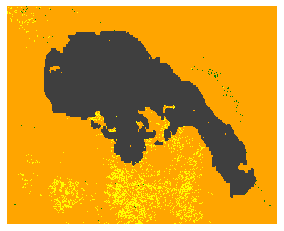

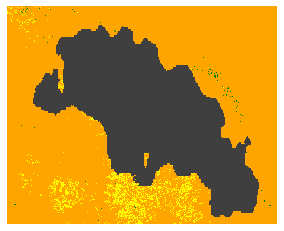

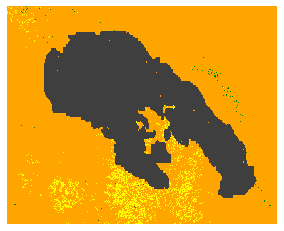

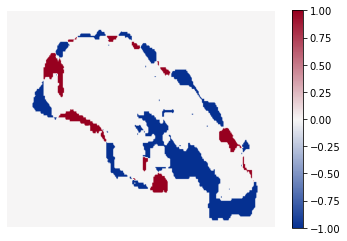

{'index': 1, 'name': 'Ranch_2018_NAT', 'total_day': 48, 'x_diff': 57016.84562631871, 'y_diff': 53639.498894194825, 'w': -123.10068046006613, 'e': -122.45768644799318, 'n': 39.53377154148058, 's': 39.036272399402996, 'wind_u': 0.690933931300648, 'wind_v': -1.1860290860422538}


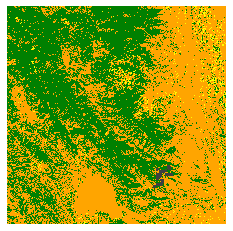

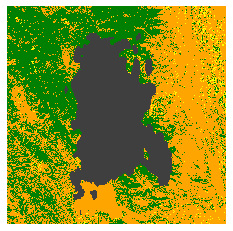

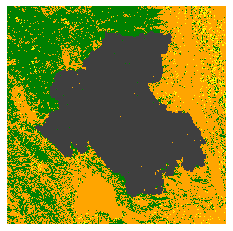

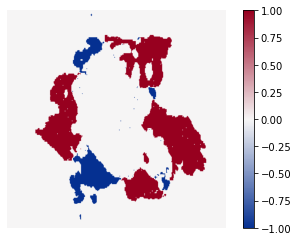

{'index': 2, 'name': 'Rim_2018_NAT', 'total_day': 19, 'x_diff': 33621.82427886273, 'y_diff': 30700.0, 'w': -120.22089239156477, 'e': -119.83793877941949, 'n': 38.07544905591572, 's': 37.79919150302073, 'wind_u': -0.9007429033645167, 'wind_v': -0.40763748941499967}


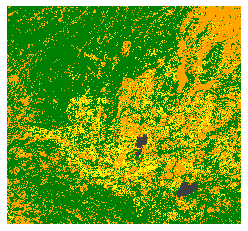

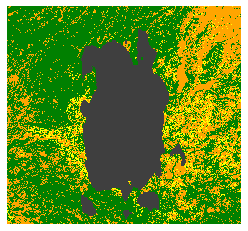

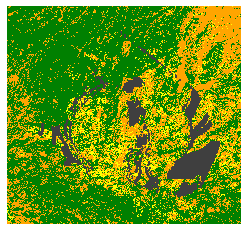

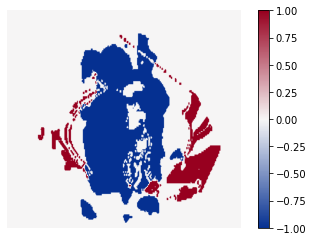

{'index': 3, 'name': 'River_2018_NAT', 'total_day': 11, 'x_diff': 19563.05606890889, 'y_diff': 20802.175823475496, 'w': -123.13440878540776, 'e': -122.9159373846225, 'n': 39.15060661323484, 's': 38.9579190639885, 'wind_u': 0.6997970353277978, 'wind_v': -1.0538874765679793}


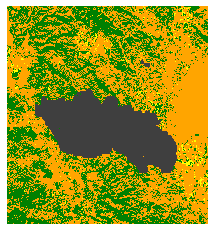

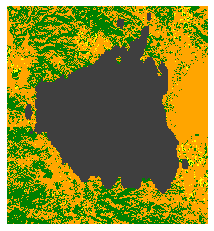

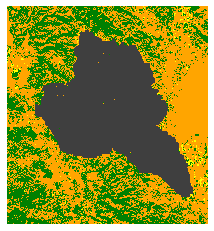

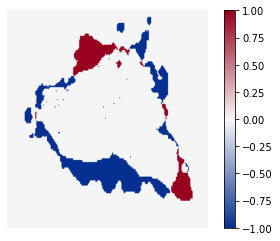

{'index': 4, 'name': 'Roosevelt_2018_NAT', 'total_day': 16, 'x_diff': 33080.231299413485, 'y_diff': 20468.36501029192, 'w': -110.61201323078151, 'e': -110.1842476632112, 'n': 43.13665576277981, 's': 42.98287434407504, 'wind_u': 1.2562464273214573, 'wind_v': 0.5881749505396565}


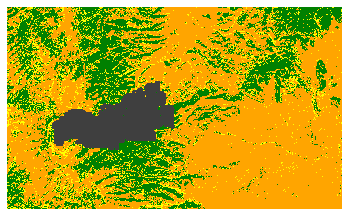

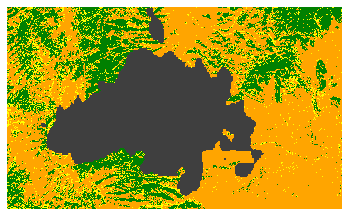

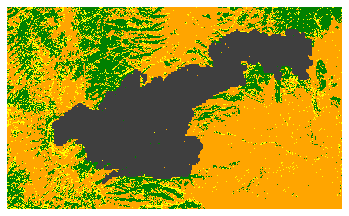

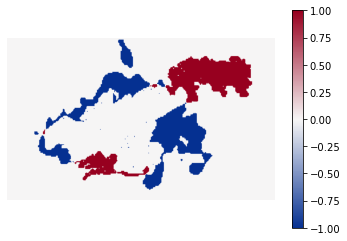

{'index': 5, 'name': 'Ryan_2018_NAT', 'total_day': 16, 'x_diff': 22121.22969404934, 'y_diff': 15678.814010114525, 'w': -106.74982763878275, 'e': -106.46331250592397, 'n': 41.08876297299563, 's': 40.97696744826533, 'wind_u': 0.6971523200299998, 'wind_v': 0.19701614700352366}


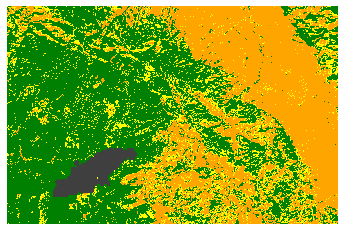

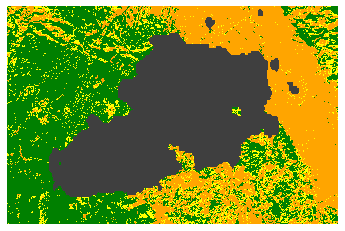

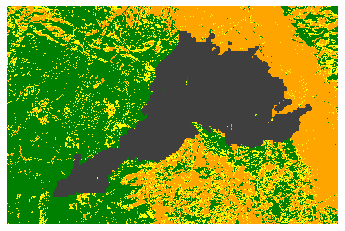

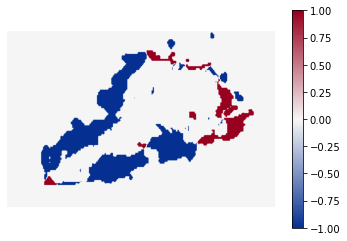

{'index': 6, 'name': 'Sharps_2018_NAT', 'total_day': 9, 'x_diff': 20490.595473823778, 'y_diff': 21407.596720009693, 'w': -114.18546587499321, 'e': -113.91715487565614, 'n': 43.62435822927681, 's': 43.44274827938838, 'wind_u': 2.615417011678801, 'wind_v': 0.15998390036060872}


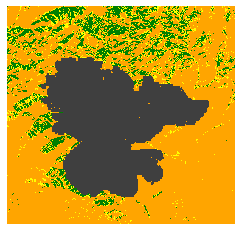

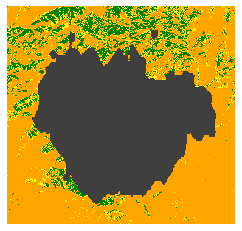

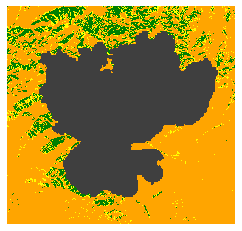

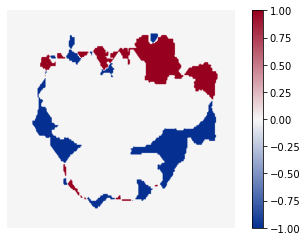

{'index': 7, 'name': 'Stone_2018_NAT', 'total_day': 16, 'x_diff': 18613.342986533884, 'y_diff': 15919.907870275085, 'w': -121.12688873719442, 'e': -120.90651725092896, 'n': 41.49873679054977, 's': 41.353444474840224, 'wind_u': 0.6785492735773495, 'wind_v': -2.133209422463551}


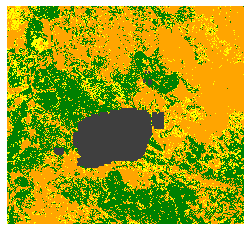

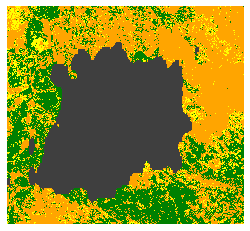

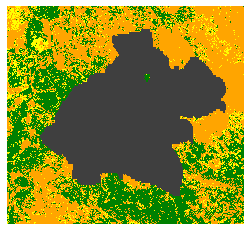

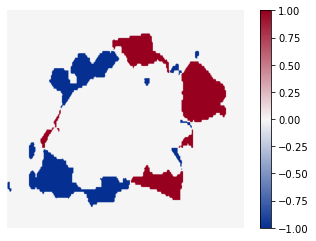

{'index': 8, 'name': 'Whaleback_2018_NAT', 'total_day': 6, 'x_diff': 10372.569207398607, 'y_diff': 11282.311658255814, 'w': -120.88788734939351, 'e': -120.76647537859333, 'n': 40.6779263405866, 's': 40.575502112863525, 'wind_u': -0.411276296277425, 'wind_v': -1.5704487977636745}


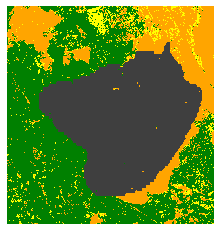

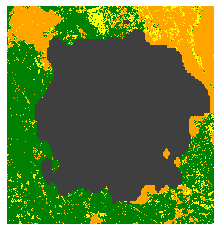

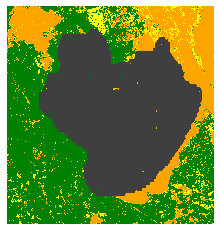

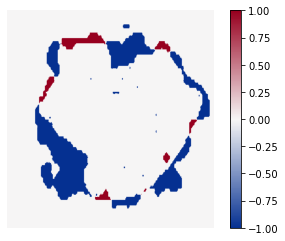

{'index': 9, 'name': 'Woolsey_2018_NAT', 'total_day': 9, 'x_diff': 31291.721823350104, 'y_diff': 25340.60644507839, 'w': -118.99224598838985, 'e': -118.64960321573858, 'n': 34.23852039831588, 's': 34.013622419183264, 'wind_u': 0.7689575184376736, 'wind_v': 0.22026773010980394}


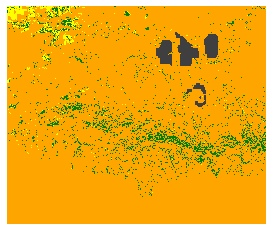

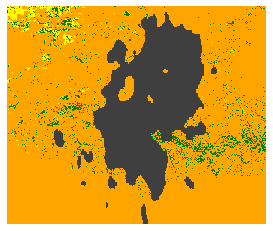

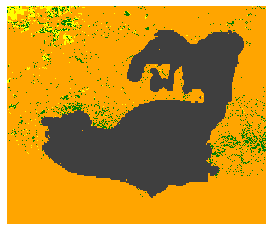

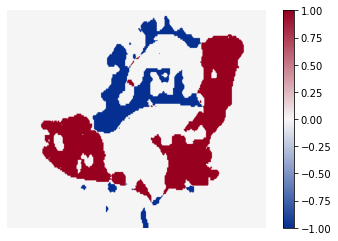

{'index': 10, 'name': 'Briceburg_2019_NAT', 'total_day': 4, 'x_diff': 5902.4813645227005, 'y_diff': 5840.505331478504, 'w': -119.96550551225076, 'e': -119.89850501243522, 'n': 37.633527357651154, 's': 37.58102612567214, 'wind_u': 0.5806992166646177, 'wind_v': -0.5004513313420356}


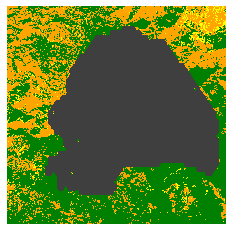

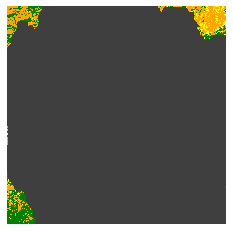

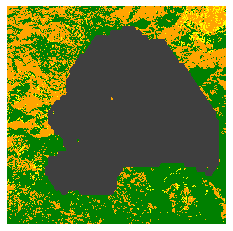

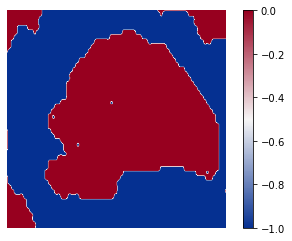

{'index': 11, 'name': 'Camp_2019_NAT', 'total_day': 13, 'x_diff': 36086.56261327639, 'y_diff': 32565.929145679955, 'w': -121.76933815522989, 'e': -121.35431873433252, 'n': 39.8987628406143, 's': 39.60034379305354, 'wind_u': -1.5187453420930979, 'wind_v': -1.1077703409486865}


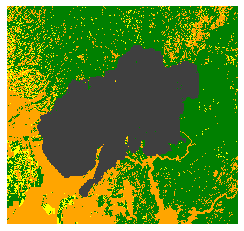

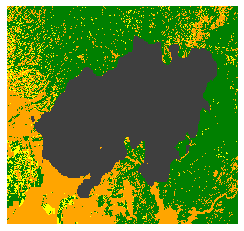

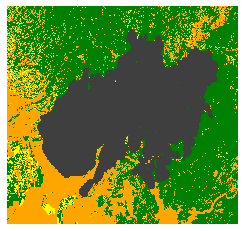

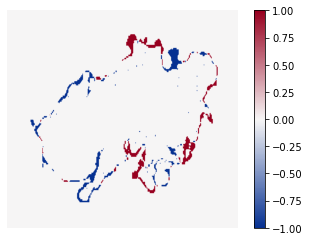

{'index': 12, 'name': 'Caples_2019_NAT', 'total_day': 11, 'x_diff': 7001.688269342478, 'y_diff': 4903.819078313973, 'w': -120.200814189617, 'e': -120.12030994903692, 'n': 38.72898635117375, 's': 38.68476229966982, 'wind_u': 0.7695218058720457, 'wind_v': 1.19099907958298}


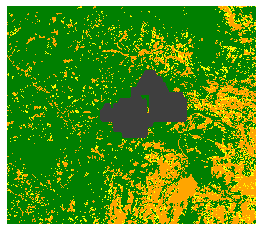

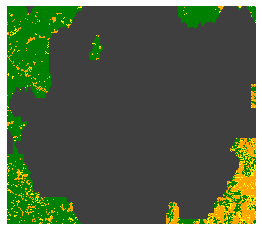

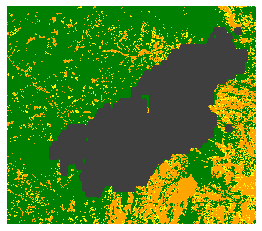

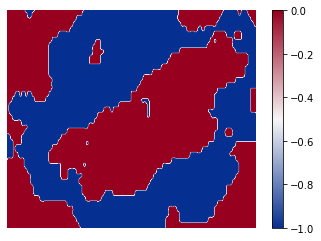

{'index': 13, 'name': 'Easy_2019_NAT', 'total_day': 11, 'x_diff': 4370.536278870844, 'y_diff': 3535.3650115915225, 'w': -118.85219112808727, 'e': -118.80425097099416, 'n': 34.283953714422545, 's': 34.25257967632218, 'wind_u': 0.40389786289597396, 'wind_v': -0.5539748531828081}


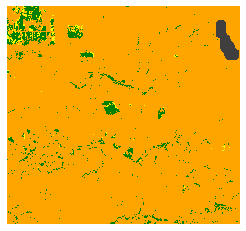

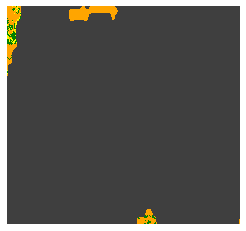

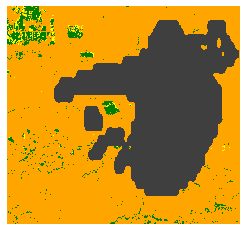

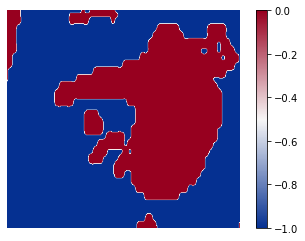

{'index': 14, 'name': 'Fishhawk_2019_NAT', 'total_day': 4, 'x_diff': 7088.695410149405, 'y_diff': 12230.240093239816, 'w': -109.90340801865584, 'e': -109.79927212365273, 'n': 44.435722936739026, 's': 44.33240544583971, 'wind_u': 1.6075665046409995, 'wind_v': 1.3424252062977757}


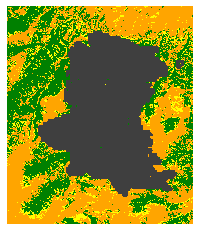

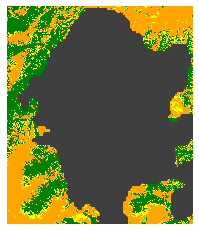

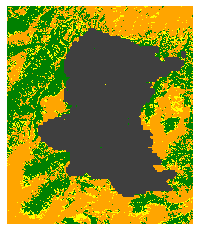

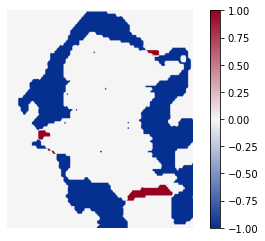

{'index': 15, 'name': 'Jordan_2019_NAT', 'total_day': 5, 'x_diff': 1765.393918380636, 'y_diff': 2159.605404377682, 'w': -118.31729295869066, 'e': -118.29720422146639, 'n': 36.2293780460396, 's': 36.210230141818045, 'wind_u': -0.5117136908047542, 'wind_v': -0.5140475986081583}


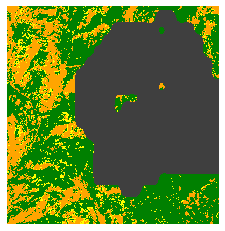

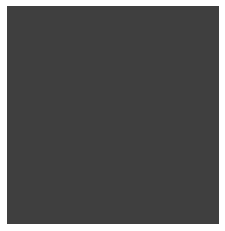

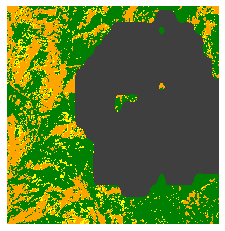

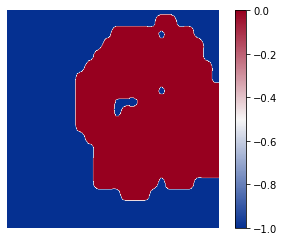

{'index': 16, 'name': 'Kincade_2019_NAT', 'total_day': 7, 'x_diff': 20403.186233716522, 'y_diff': 31833.8118357754, 'w': -122.88578520666536, 'e': -122.66183702437559, 'n': 38.81864181387295, 's': 38.52700509394568, 'wind_u': 0.9748612323595667, 'wind_v': -1.4734813356517407}


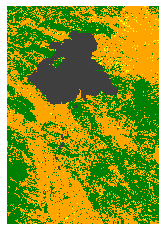

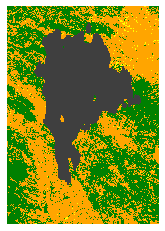

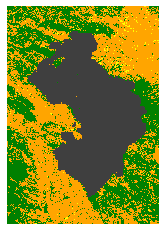

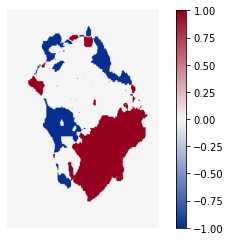

{'index': 17, 'name': 'Lime_2019_NAT', 'total_day': 4, 'x_diff': 2973.5576204049576, 'y_diff': 3826.965088117344, 'w': -122.6781690192858, 'e': -122.64372113915994, 'n': 41.88339530418474, 's': 41.84814110069589, 'wind_u': 1.1240611663779418, 'wind_v': -0.369932080174749}


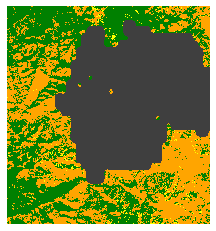

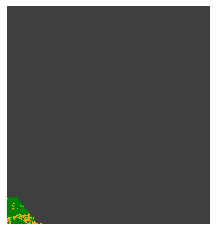

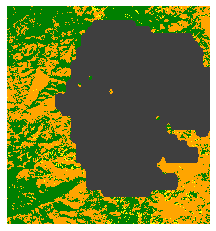

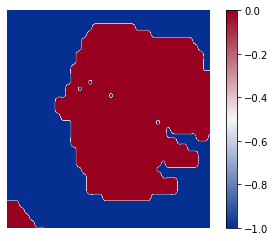

{'index': 18, 'name': 'Lincoln_2019_NAT', 'total_day': 4, 'x_diff': 1113.3781371164368, 'y_diff': 1914.7516927452525, 'w': -116.07923471337843, 'e': -116.06641019398394, 'n': 33.54674451537603, 's': 33.52990384086532, 'wind_u': 1.9399078786373138, 'wind_v': 0.08258840360303443}


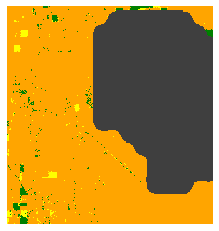

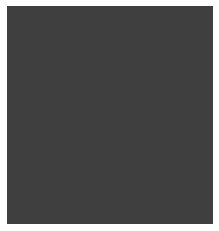

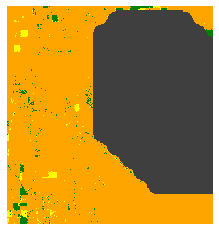

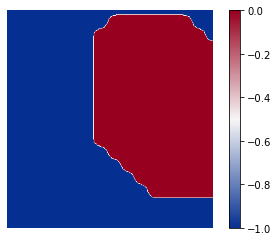

{'index': 19, 'name': 'Middle_2019_NAT', 'total_day': 10, 'x_diff': 3900.7393520426995, 'y_diff': 2352.7019106477965, 'w': -123.02552888733678, 'e': -122.98017403556481, 'n': 40.89448859064096, 's': 40.87219195884158, 'wind_u': 0.9727488489661482, 'wind_v': 0.24561662518135563}


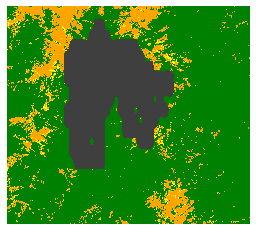

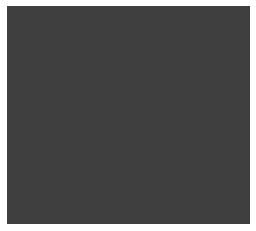

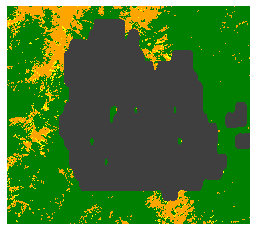

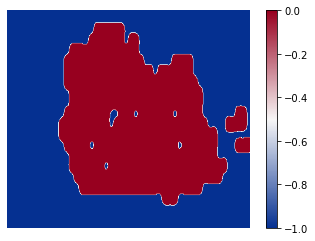

{'index': 20, 'name': 'Neck_2019_NAT', 'total_day': 4, 'x_diff': 12065.206159088877, 'y_diff': 10971.511688532355, 'w': -113.21196419912742, 'e': -113.06555976552065, 'n': 38.11760895299647, 's': 38.027020418431924, 'wind_u': 1.0576831962607685, 'wind_v': 2.394872149452567}


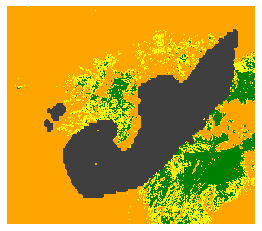

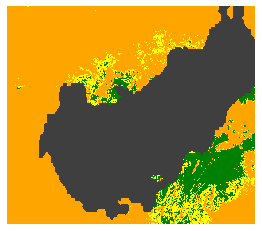

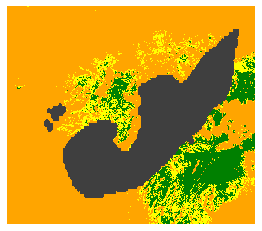

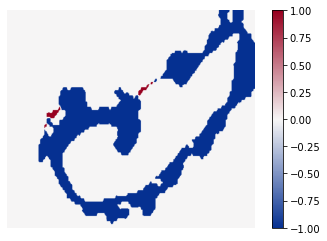

{'index': 21, 'name': 'Ranch_2019_NAT', 'total_day': 5, 'x_diff': 3932.3910661116824, 'y_diff': 4494.576387303765, 'w': -122.65207434699342, 'e': -122.60744543957472, 'n': 40.07661917465535, 's': 40.03519131855303, 'wind_u': 0.5937479940371316, 'wind_v': -0.5743505690879829}


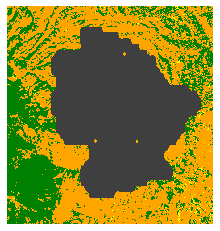

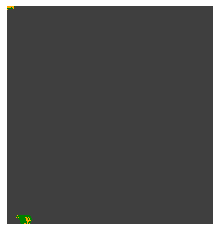

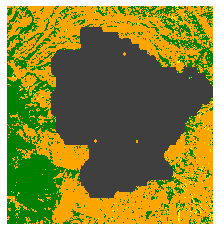

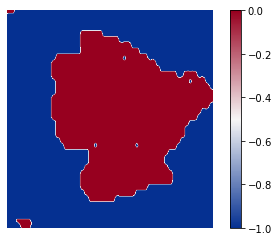

{'index': 22, 'name': 'South_2019_NAT', 'total_day': 10, 'x_diff': 8420.497254038375, 'y_diff': 7527.836953263119, 'w': -122.8709341997094, 'e': -122.77479363216499, 'n': 40.15233872011793, 's': 40.08234099171588, 'wind_u': 0.7863110255502761, 'wind_v': 0.19767953307189634}


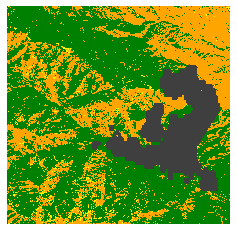

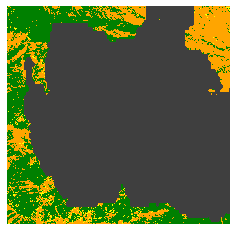

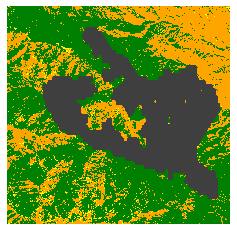

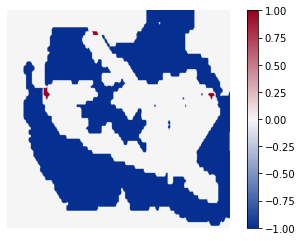

{'index': 23, 'name': 'Springs_2019_NAT', 'total_day': 6, 'x_diff': 2729.300436638863, 'y_diff': 5170.17321099171, 'w': -118.90051457699938, 'e': -118.8687747468267, 'n': 37.85053063441289, 's': 37.80431422469345, 'wind_u': 1.3355229732842417, 'wind_v': 1.3317025621363427}


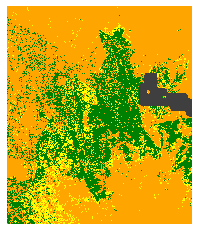

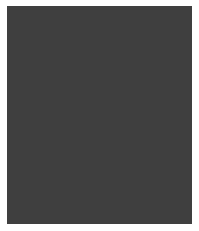

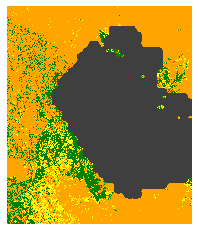

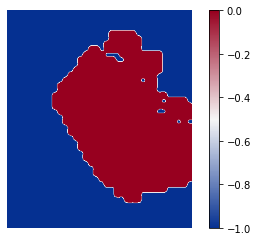

{'index': 24, 'name': 'Taboose_2019_NAT', 'total_day': 6, 'x_diff': 5820.85898435628, 'y_diff': 5768.896215249246, 'w': -118.39118723198803, 'e': -118.32457132429893, 'n': 37.02880170738101, 's': 36.97781604449291, 'wind_u': 1.0563169609249599, 'wind_v': 0.687188895753934}


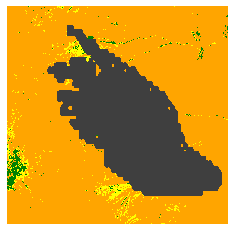

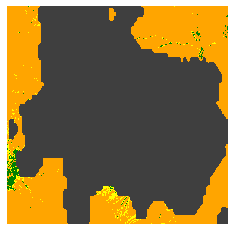

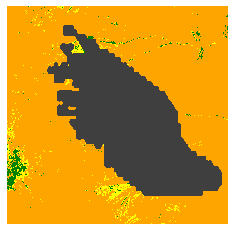

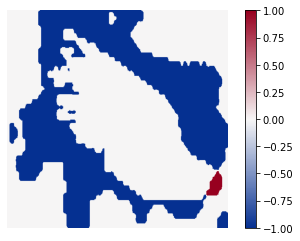

{'index': 25, 'name': 'Thomas_2019_NAT', 'total_day': 20, 'x_diff': 49901.688269342485, 'y_diff': 14700.0, 'w': -119.49161772132688, 'e': -118.94759079822332, 'n': 34.43927901581883, 's': 34.31051009105449, 'wind_u': -0.95892514947991, 'wind_v': -1.5021506729463}


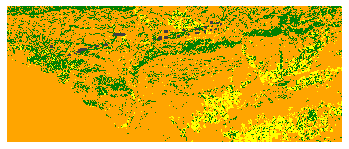

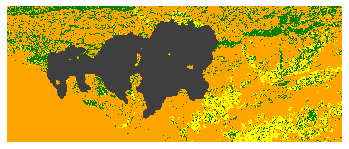

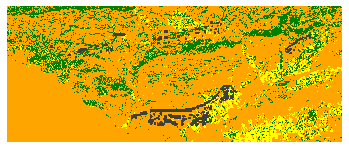

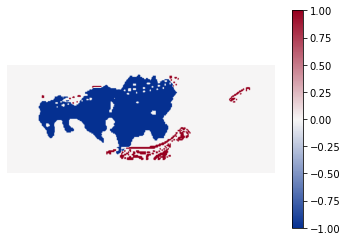

{'index': 26, 'name': 'Tick_2019_NAT', 'total_day': 4, 'x_diff': 7363.1396082676365, 'y_diff': 5302.827137240558, 'w': -118.43176452688488, 'e': -118.3506392934236, 'n': 34.47276429901481, 's': 34.42611296984244, 'wind_u': 1.3910121798398905, 'wind_v': -0.8601582999217499}


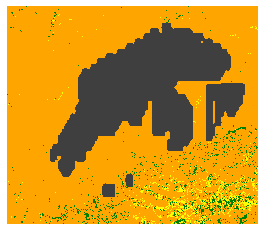

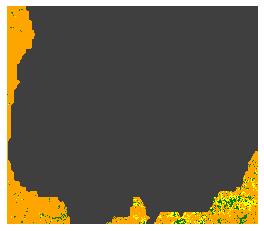

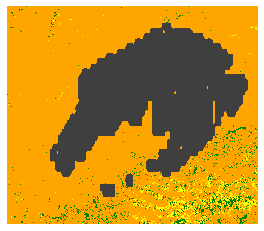

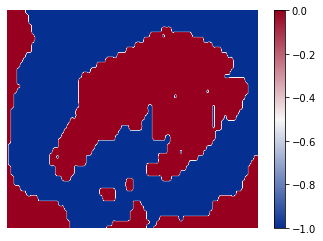

{'index': 27, 'name': 'Valley_2019_NAT', 'total_day': 5, 'x_diff': 15100.0, 'y_diff': 10701.688269342485, 'w': -122.74497303969278, 'e': -122.57444305705067, 'n': 38.85667475880516, 's': 38.75662207297709, 'wind_u': -1.0810222889485885, 'wind_v': -2.9216695459617767}


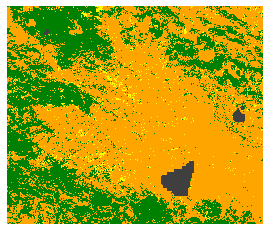

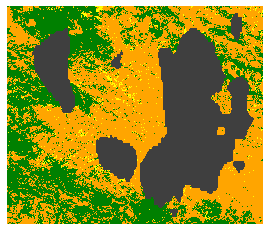

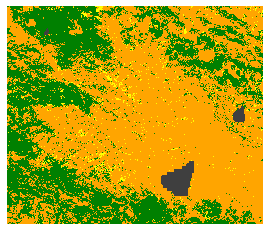

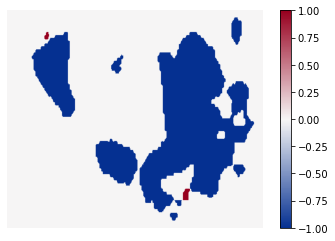

{'index': 28, 'name': 'Walker_2019_NAT', 'total_day': 13, 'x_diff': 20894.912801356506, 'y_diff': 18926.544360016414, 'w': -120.70826664701102, 'e': -120.46453432402458, 'n': 40.17682064591035, 's': 40.00527393878114, 'wind_u': 1.202021376186167, 'wind_v': 1.2295505096699344}


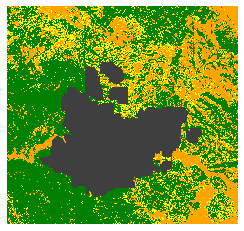

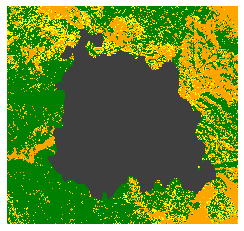

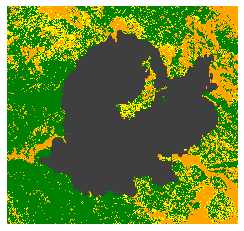

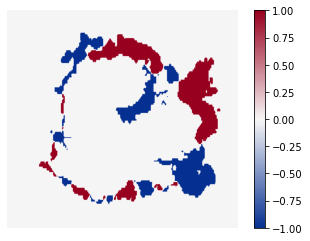

{'index': 29, 'name': 'Woodbury_2019_NAT', 'total_day': 21, 'x_diff': 34992.426308362396, 'y_diff': 34192.12673638039, 'w': -111.38298725610495, 'e': -110.97395981264307, 'n': 33.65821397863832, 's': 33.380447807578754, 'wind_u': 0.8093778732691135, 'wind_v': 1.4247647043521283}


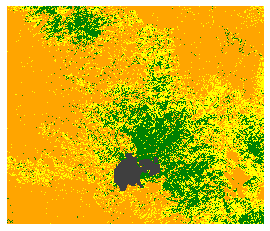

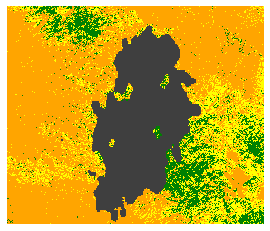

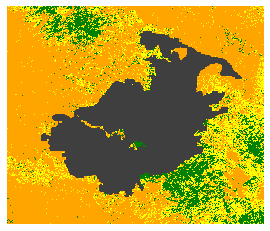

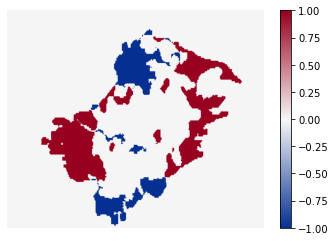

{'index': 30, 'name': 'Apple_2020_NAT', 'total_day': 17, 'x_diff': 17802.281911168946, 'y_diff': 13061.802842946374, 'w': -116.9635423968264, 'e': -116.76619534660031, 'n': 34.08822569214675, 's': 33.97584485618339, 'wind_u': 0.0, 'wind_v': 0.0}


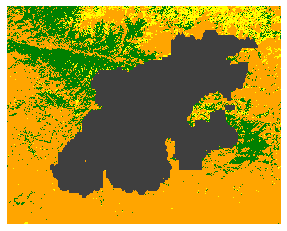

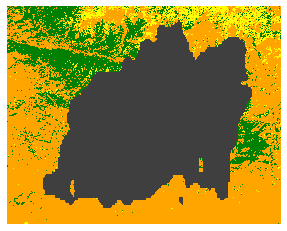

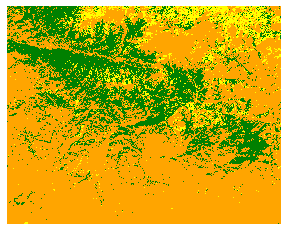

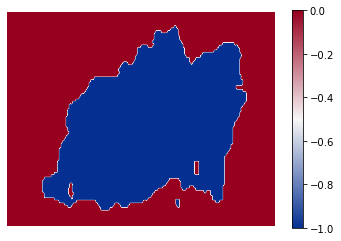

In [23]:
for fire_index in fire_index_list:
    fire_name = fire_list[fire_index]
    # Load Fire info
    with open(f"./CA/data/{fire_index}_info_{fire_name}.json", 'r') as load_f:
        fire_info = json.load(load_f)

    # Read Forest
    forest = Image.open(f'./CA/data/{fire_index}_canopy_{fire_name}.tif')
    forest = np.array(forest)
    forest[forest < -999.] = 0.
    forest = forest/np.max(forest)

    # Get Input Data and truth
    example = dataset[fire_index]
    frames = example[..., :-1]

    fidn_pred_binary_512 = fidn_model.predict(
            np.expand_dims(frames, axis=0), verbose=0)

    truth_binary_512 = example[..., -1:]
    truth_binary_512 = truth_binary_512.astype(np.float32)

    fidn_pred_binary_512 = np.squeeze(fidn_pred_binary_512)
    truth_binary_512 = np.squeeze(truth_binary_512)

    threshold = 0.1

    fidn_pred_binary_512[fidn_pred_binary_512 >= threshold] = 1
    fidn_pred_binary_512[fidn_pred_binary_512 < threshold] = 0

    error_fidn_512 = truth_binary_512 - fidn_pred_binary_512

    print(fire_info)

    day2_binary_432 = convert_512_fire_to_432(np.squeeze(example[..., 2]), fire_info)
    fidn_pred_binary_432 = convert_512_fire_to_432(fidn_pred_binary_512, fire_info)
    truth_binary_432 = convert_512_fire_to_432(truth_binary_512, fire_info)
    
    day2_binary = fire_reshape(day2_binary_432, (forest.shape[1], forest.shape[0]))
    fidn_pred_binary = fire_reshape(fidn_pred_binary_432, (forest.shape[1], forest.shape[0]))
    truth_binary = fire_reshape(truth_binary_432, (forest.shape[1], forest.shape[0]))
    error_fidn = truth_binary - fidn_pred_binary
    
    day2_forest_array = convert_binary_to_forest_array(day2_binary)
    plt.imshow(forest + day2_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/fidn/{fire_index}_{fire_name}_day2.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()
    
    fidn_forest_array = convert_binary_to_forest_array(fidn_pred_binary)
    plt.imshow(forest + fidn_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/fidn/{fire_index}_{fire_name}_predict.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()

    truth_forest_array = convert_binary_to_forest_array(truth_binary)
    plt.imshow(forest + truth_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/fidn/{fire_index}_{fire_name}_truth.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()


    clist=['#053091','#f7f6f6','#97001f']
    newcmp = LinearSegmentedColormap.from_list('error',clist)
    plt.imshow(error_fidn,cmap=newcmp)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/fidn/{fire_index}_{fire_name}_error.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.colorbar()
    plt.show()
    plt.close()

## CA Evaluate

{'index': 0, 'name': 'Perry_2018_NAT', 'total_day': 6, 'x_diff': 24786.635221107208, 'y_diff': 18342.05169621861, 'w': -119.63641053638074, 'e': -119.34565117346524, 'n': 39.88372696696042, 's': 39.719832982492676, 'wind_u': 0.04540517985556697, 'wind_v': -0.7248370459401485}


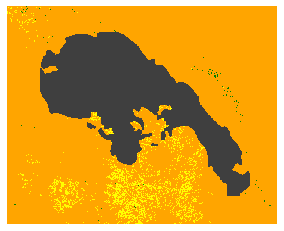

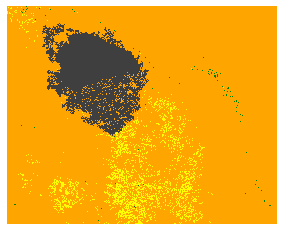

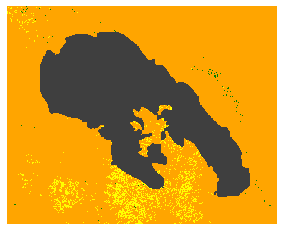

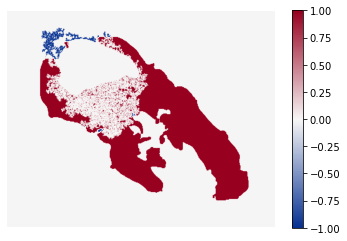

{'index': 1, 'name': 'Ranch_2018_NAT', 'total_day': 48, 'x_diff': 57016.84562631871, 'y_diff': 53639.498894194825, 'w': -123.10068046006613, 'e': -122.45768644799318, 'n': 39.53377154148058, 's': 39.036272399402996, 'wind_u': 0.690933931300648, 'wind_v': -1.1860290860422538}


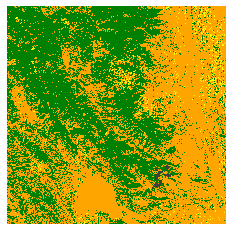

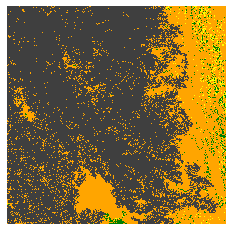

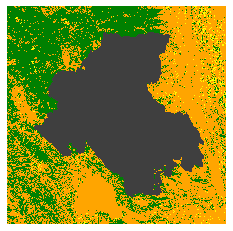

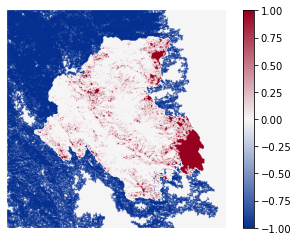

{'index': 2, 'name': 'Rim_2018_NAT', 'total_day': 19, 'x_diff': 33621.82427886273, 'y_diff': 30700.0, 'w': -120.22089239156477, 'e': -119.83793877941949, 'n': 38.07544905591572, 's': 37.79919150302073, 'wind_u': -0.9007429033645167, 'wind_v': -0.40763748941499967}


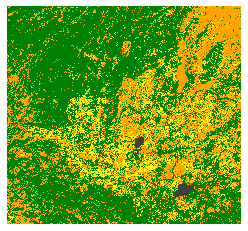

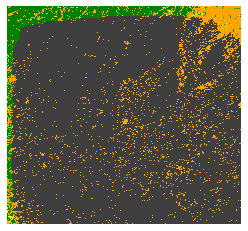

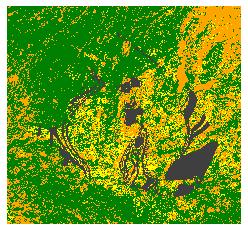

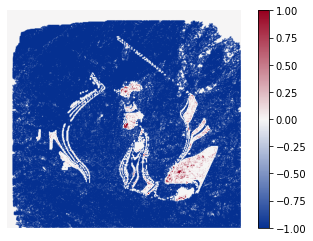

{'index': 3, 'name': 'River_2018_NAT', 'total_day': 11, 'x_diff': 19563.05606890889, 'y_diff': 20802.175823475496, 'w': -123.13440878540776, 'e': -122.9159373846225, 'n': 39.15060661323484, 's': 38.9579190639885, 'wind_u': 0.6997970353277978, 'wind_v': -1.0538874765679793}


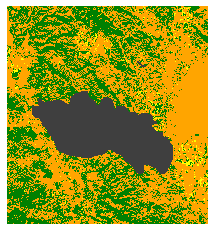

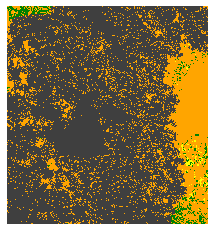

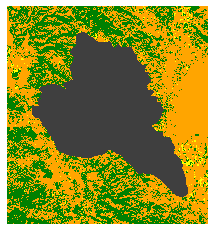

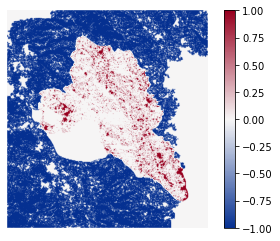

{'index': 4, 'name': 'Roosevelt_2018_NAT', 'total_day': 16, 'x_diff': 33080.231299413485, 'y_diff': 20468.36501029192, 'w': -110.61201323078151, 'e': -110.1842476632112, 'n': 43.13665576277981, 's': 42.98287434407504, 'wind_u': 1.2562464273214573, 'wind_v': 0.5881749505396565}


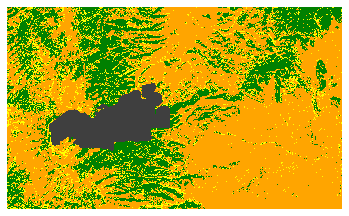

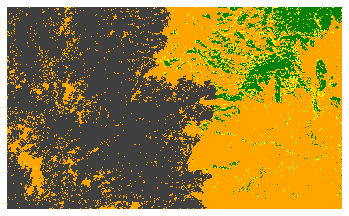

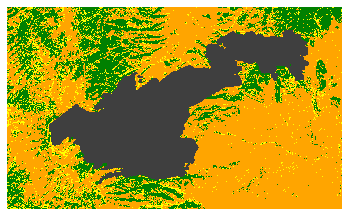

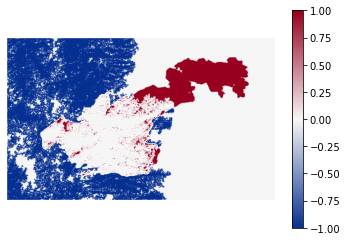

{'index': 5, 'name': 'Ryan_2018_NAT', 'total_day': 16, 'x_diff': 22121.22969404934, 'y_diff': 15678.814010114525, 'w': -106.74982763878275, 'e': -106.46331250592397, 'n': 41.08876297299563, 's': 40.97696744826533, 'wind_u': 0.6971523200299998, 'wind_v': 0.19701614700352366}


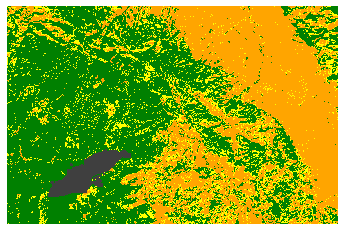

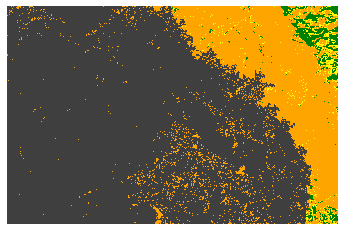

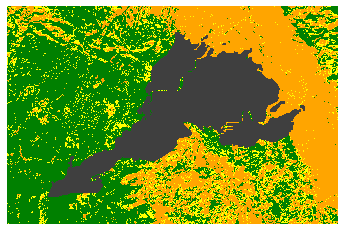

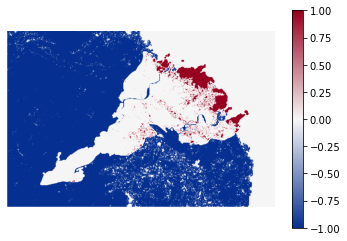

{'index': 6, 'name': 'Sharps_2018_NAT', 'total_day': 9, 'x_diff': 20490.595473823778, 'y_diff': 21407.596720009693, 'w': -114.18546587499321, 'e': -113.91715487565614, 'n': 43.62435822927681, 's': 43.44274827938838, 'wind_u': 2.615417011678801, 'wind_v': 0.15998390036060872}


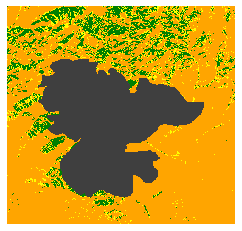

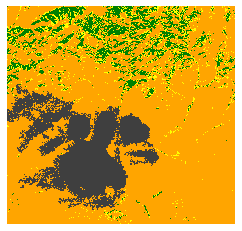

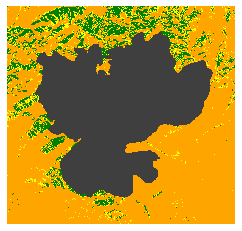

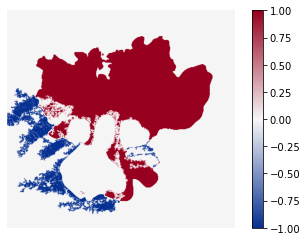

{'index': 7, 'name': 'Stone_2018_NAT', 'total_day': 16, 'x_diff': 18613.342986533884, 'y_diff': 15919.907870275085, 'w': -121.12688873719442, 'e': -120.90651725092896, 'n': 41.49873679054977, 's': 41.353444474840224, 'wind_u': 0.6785492735773495, 'wind_v': -2.133209422463551}


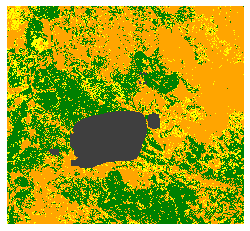

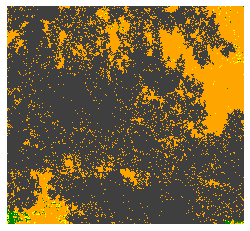

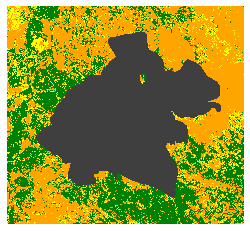

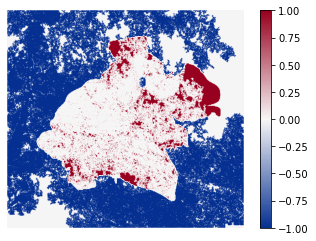

{'index': 8, 'name': 'Whaleback_2018_NAT', 'total_day': 6, 'x_diff': 10372.569207398607, 'y_diff': 11282.311658255814, 'w': -120.88788734939351, 'e': -120.76647537859333, 'n': 40.6779263405866, 's': 40.575502112863525, 'wind_u': -0.411276296277425, 'wind_v': -1.5704487977636745}


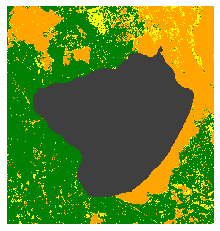

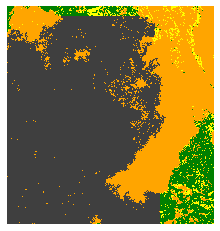

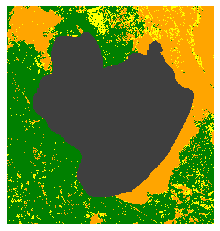

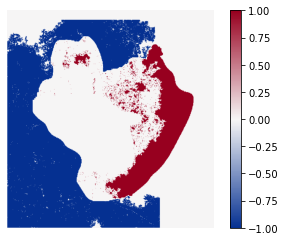

{'index': 9, 'name': 'Woolsey_2018_NAT', 'total_day': 9, 'x_diff': 31291.721823350104, 'y_diff': 25340.60644507839, 'w': -118.99224598838985, 'e': -118.64960321573858, 'n': 34.23852039831588, 's': 34.013622419183264, 'wind_u': 0.7689575184376736, 'wind_v': 0.22026773010980394}


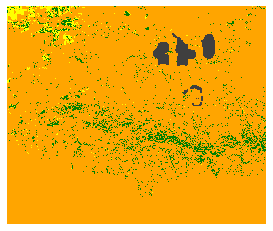

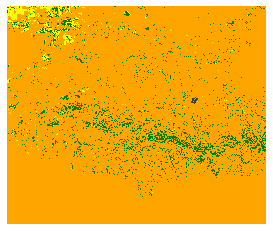

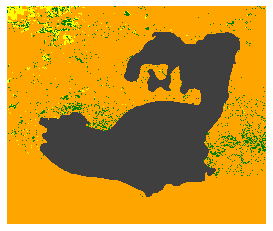

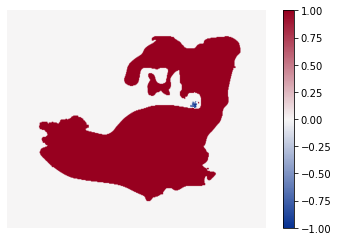

{'index': 10, 'name': 'Briceburg_2019_NAT', 'total_day': 4, 'x_diff': 5902.4813645227005, 'y_diff': 5840.505331478504, 'w': -119.96550551225076, 'e': -119.89850501243522, 'n': 37.633527357651154, 's': 37.58102612567214, 'wind_u': 0.5806992166646177, 'wind_v': -0.5004513313420356}


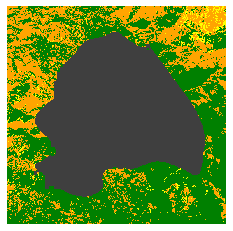

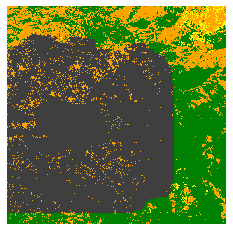

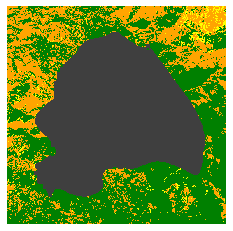

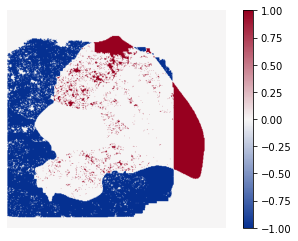

{'index': 11, 'name': 'Camp_2019_NAT', 'total_day': 13, 'x_diff': 36086.56261327639, 'y_diff': 32565.929145679955, 'w': -121.76933815522989, 'e': -121.35431873433252, 'n': 39.8987628406143, 's': 39.60034379305354, 'wind_u': -1.5187453420930979, 'wind_v': -1.1077703409486865}


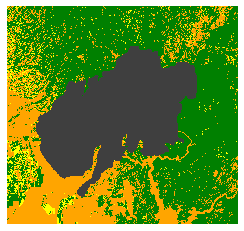

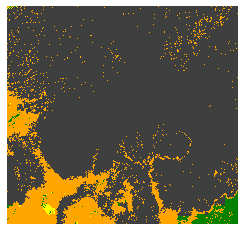

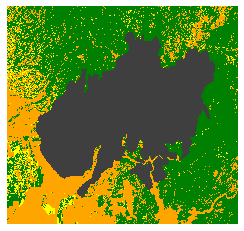

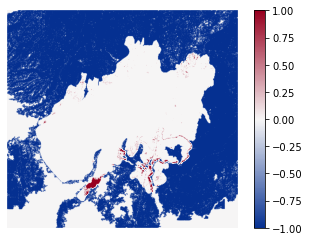

{'index': 12, 'name': 'Caples_2019_NAT', 'total_day': 11, 'x_diff': 7001.688269342478, 'y_diff': 4903.819078313973, 'w': -120.200814189617, 'e': -120.12030994903692, 'n': 38.72898635117375, 's': 38.68476229966982, 'wind_u': 0.7695218058720457, 'wind_v': 1.19099907958298}


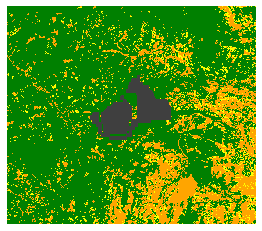

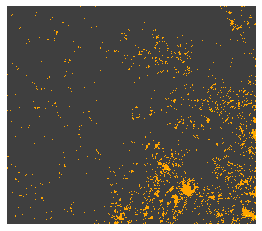

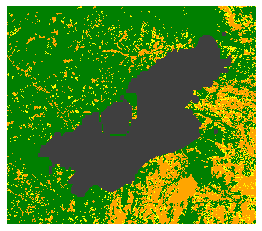

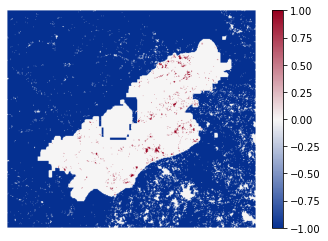

{'index': 13, 'name': 'Easy_2019_NAT', 'total_day': 11, 'x_diff': 4370.536278870844, 'y_diff': 3535.3650115915225, 'w': -118.85219112808727, 'e': -118.80425097099416, 'n': 34.283953714422545, 's': 34.25257967632218, 'wind_u': 0.40389786289597396, 'wind_v': -0.5539748531828081}


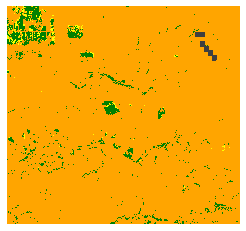

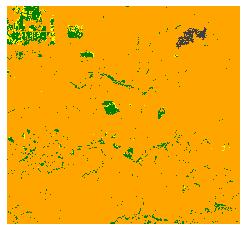

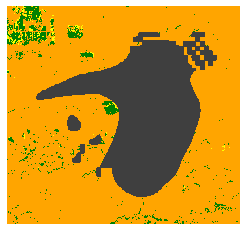

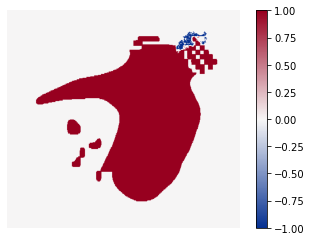

{'index': 14, 'name': 'Fishhawk_2019_NAT', 'total_day': 4, 'x_diff': 7088.695410149405, 'y_diff': 12230.240093239816, 'w': -109.90340801865584, 'e': -109.79927212365273, 'n': 44.435722936739026, 's': 44.33240544583971, 'wind_u': 1.6075665046409995, 'wind_v': 1.3424252062977757}


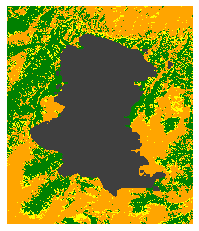

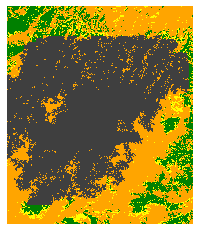

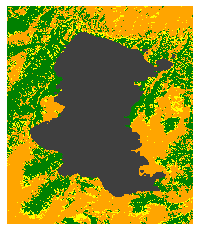

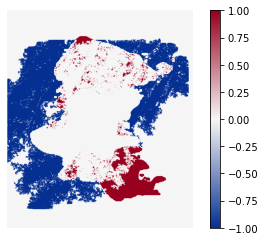

{'index': 15, 'name': 'Jordan_2019_NAT', 'total_day': 5, 'x_diff': 1765.393918380636, 'y_diff': 2159.605404377682, 'w': -118.31729295869066, 'e': -118.29720422146639, 'n': 36.2293780460396, 's': 36.210230141818045, 'wind_u': -0.5117136908047542, 'wind_v': -0.5140475986081583}


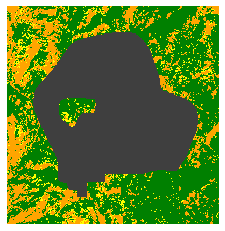

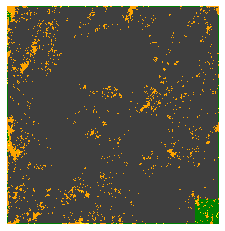

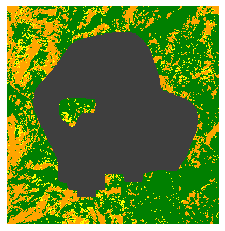

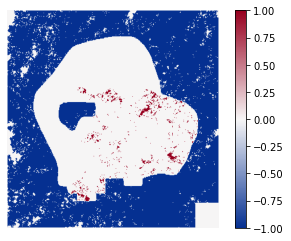

{'index': 16, 'name': 'Kincade_2019_NAT', 'total_day': 7, 'x_diff': 20403.186233716522, 'y_diff': 31833.8118357754, 'w': -122.88578520666536, 'e': -122.66183702437559, 'n': 38.81864181387295, 's': 38.52700509394568, 'wind_u': 0.9748612323595667, 'wind_v': -1.4734813356517407}


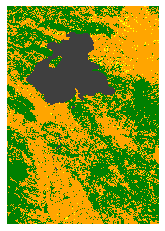

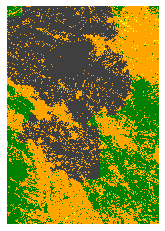

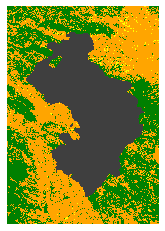

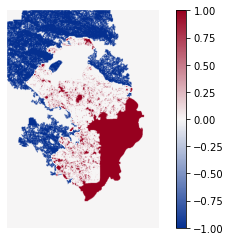

{'index': 17, 'name': 'Lime_2019_NAT', 'total_day': 4, 'x_diff': 2973.5576204049576, 'y_diff': 3826.965088117344, 'w': -122.6781690192858, 'e': -122.64372113915994, 'n': 41.88339530418474, 's': 41.84814110069589, 'wind_u': 1.1240611663779418, 'wind_v': -0.369932080174749}


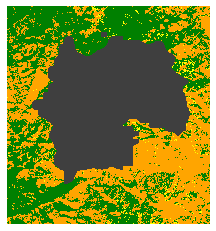

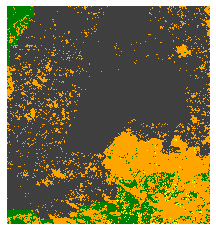

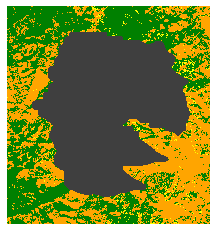

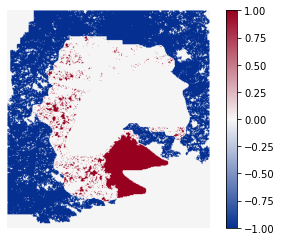

{'index': 18, 'name': 'Lincoln_2019_NAT', 'total_day': 4, 'x_diff': 1113.3781371164368, 'y_diff': 1914.7516927452525, 'w': -116.07923471337843, 'e': -116.06641019398394, 'n': 33.54674451537603, 's': 33.52990384086532, 'wind_u': 1.9399078786373138, 'wind_v': 0.08258840360303443}


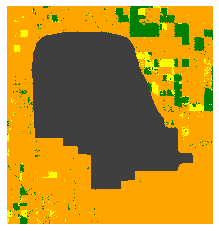

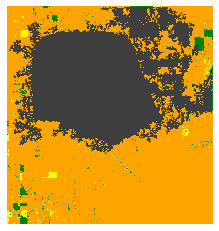

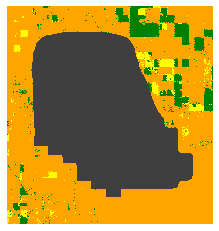

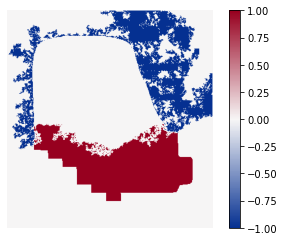

{'index': 19, 'name': 'Middle_2019_NAT', 'total_day': 10, 'x_diff': 3900.7393520426995, 'y_diff': 2352.7019106477965, 'w': -123.02552888733678, 'e': -122.98017403556481, 'n': 40.89448859064096, 's': 40.87219195884158, 'wind_u': 0.9727488489661482, 'wind_v': 0.24561662518135563}


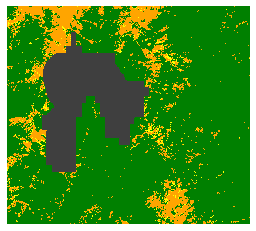

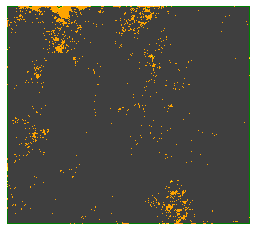

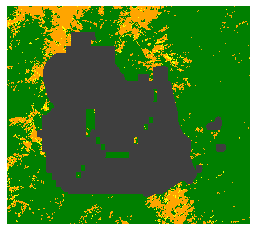

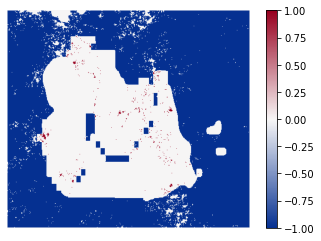

{'index': 20, 'name': 'Neck_2019_NAT', 'total_day': 4, 'x_diff': 12065.206159088877, 'y_diff': 10971.511688532355, 'w': -113.21196419912742, 'e': -113.06555976552065, 'n': 38.11760895299647, 's': 38.027020418431924, 'wind_u': 1.0576831962607685, 'wind_v': 2.394872149452567}


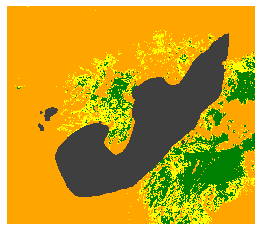

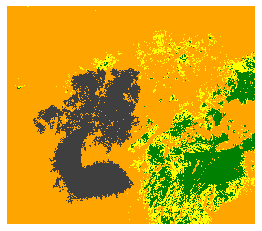

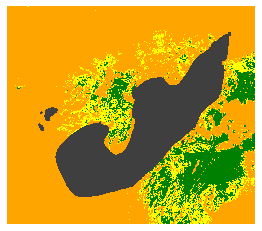

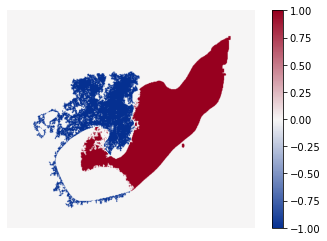

{'index': 21, 'name': 'Ranch_2019_NAT', 'total_day': 5, 'x_diff': 3932.3910661116824, 'y_diff': 4494.576387303765, 'w': -122.65207434699342, 'e': -122.60744543957472, 'n': 40.07661917465535, 's': 40.03519131855303, 'wind_u': 0.5937479940371316, 'wind_v': -0.5743505690879829}


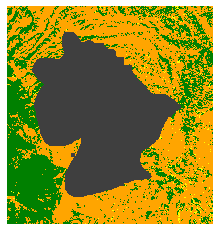

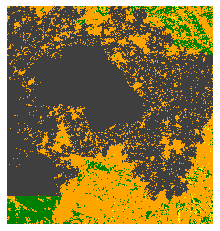

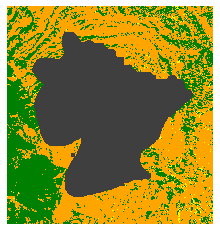

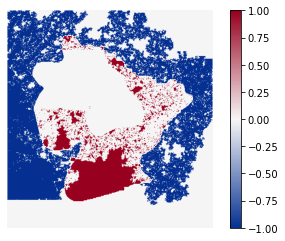

{'index': 22, 'name': 'South_2019_NAT', 'total_day': 10, 'x_diff': 8420.497254038375, 'y_diff': 7527.836953263119, 'w': -122.8709341997094, 'e': -122.77479363216499, 'n': 40.15233872011793, 's': 40.08234099171588, 'wind_u': 0.7863110255502761, 'wind_v': 0.19767953307189634}


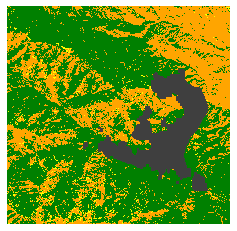

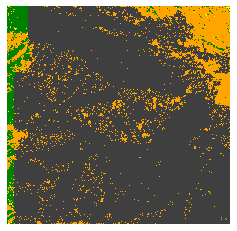

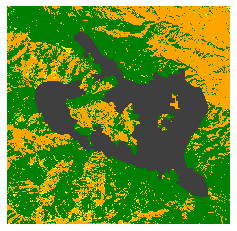

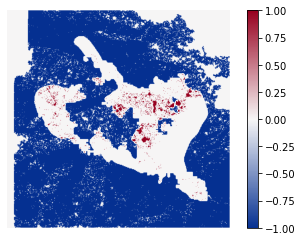

{'index': 23, 'name': 'Springs_2019_NAT', 'total_day': 6, 'x_diff': 2729.300436638863, 'y_diff': 5170.17321099171, 'w': -118.90051457699938, 'e': -118.8687747468267, 'n': 37.85053063441289, 's': 37.80431422469345, 'wind_u': 1.3355229732842417, 'wind_v': 1.3317025621363427}


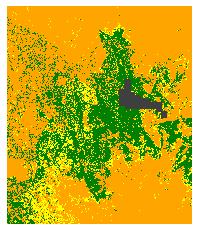

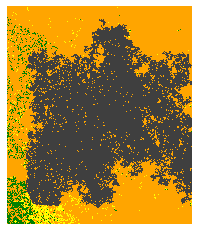

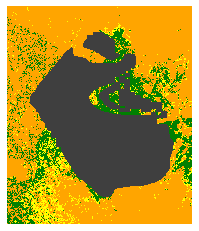

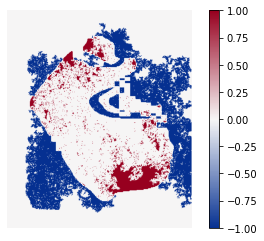

{'index': 24, 'name': 'Taboose_2019_NAT', 'total_day': 6, 'x_diff': 5820.85898435628, 'y_diff': 5768.896215249246, 'w': -118.39118723198803, 'e': -118.32457132429893, 'n': 37.02880170738101, 's': 36.97781604449291, 'wind_u': 1.0563169609249599, 'wind_v': 0.687188895753934}


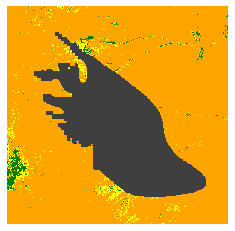

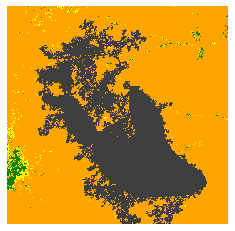

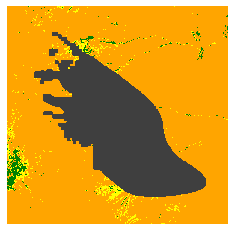

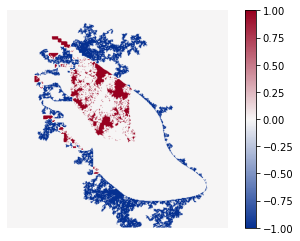

{'index': 25, 'name': 'Thomas_2019_NAT', 'total_day': 20, 'x_diff': 49901.688269342485, 'y_diff': 14700.0, 'w': -119.49161772132688, 'e': -118.94759079822332, 'n': 34.43927901581883, 's': 34.31051009105449, 'wind_u': -0.95892514947991, 'wind_v': -1.5021506729463}


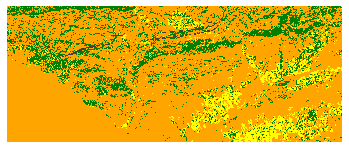

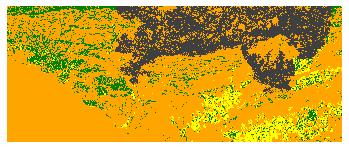

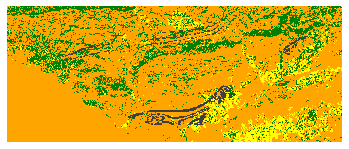

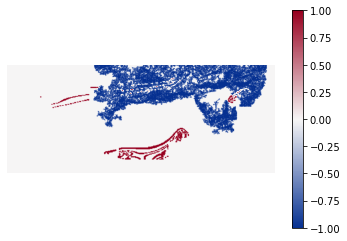

{'index': 26, 'name': 'Tick_2019_NAT', 'total_day': 4, 'x_diff': 7363.1396082676365, 'y_diff': 5302.827137240558, 'w': -118.43176452688488, 'e': -118.3506392934236, 'n': 34.47276429901481, 's': 34.42611296984244, 'wind_u': 1.3910121798398905, 'wind_v': -0.8601582999217499}


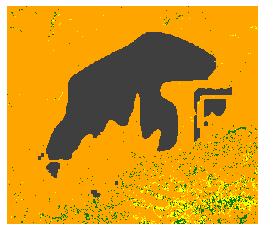

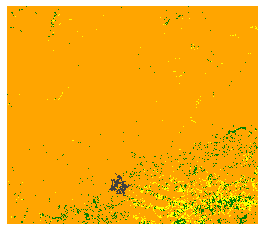

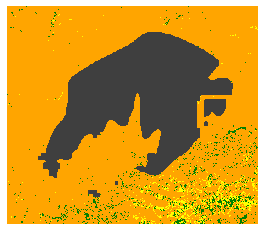

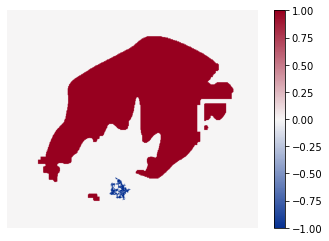

{'index': 27, 'name': 'Valley_2019_NAT', 'total_day': 5, 'x_diff': 15100.0, 'y_diff': 10701.688269342485, 'w': -122.74497303969278, 'e': -122.57444305705067, 'n': 38.85667475880516, 's': 38.75662207297709, 'wind_u': -1.0810222889485885, 'wind_v': -2.9216695459617767}


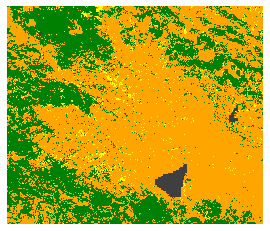

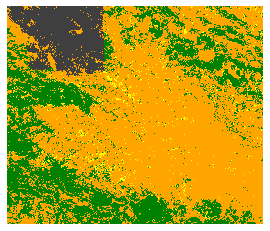

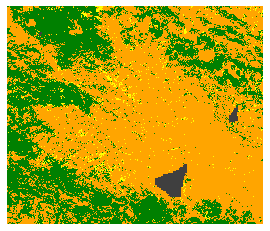

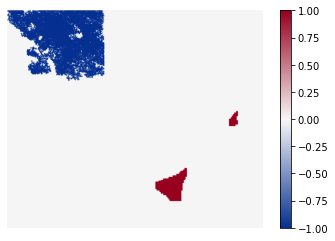

{'index': 28, 'name': 'Walker_2019_NAT', 'total_day': 13, 'x_diff': 20894.912801356506, 'y_diff': 18926.544360016414, 'w': -120.70826664701102, 'e': -120.46453432402458, 'n': 40.17682064591035, 's': 40.00527393878114, 'wind_u': 1.202021376186167, 'wind_v': 1.2295505096699344}


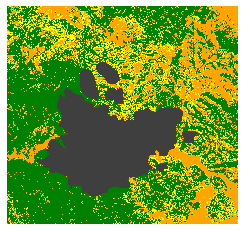

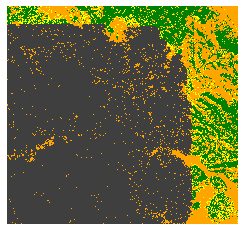

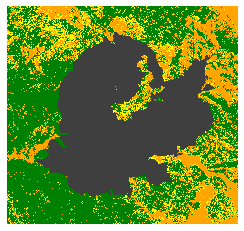

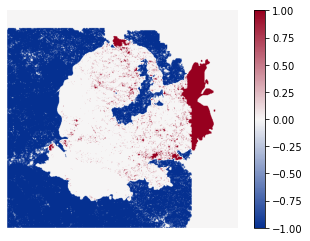

{'index': 29, 'name': 'Woodbury_2019_NAT', 'total_day': 21, 'x_diff': 34992.426308362396, 'y_diff': 34192.12673638039, 'w': -111.38298725610495, 'e': -110.97395981264307, 'n': 33.65821397863832, 's': 33.380447807578754, 'wind_u': 0.8093778732691135, 'wind_v': 1.4247647043521283}


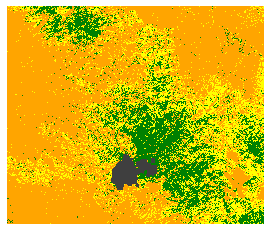

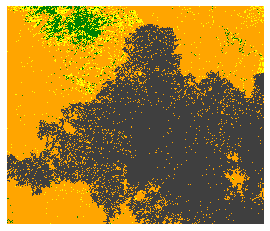

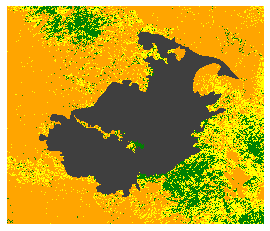

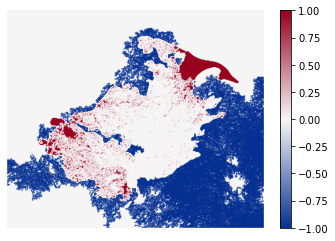

{'index': 30, 'name': 'Apple_2020_NAT', 'total_day': 17, 'x_diff': 17802.281911168946, 'y_diff': 13061.802842946374, 'w': -116.9635423968264, 'e': -116.76619534660031, 'n': 34.08822569214675, 's': 33.97584485618339, 'wind_u': 0.0, 'wind_v': 0.0}


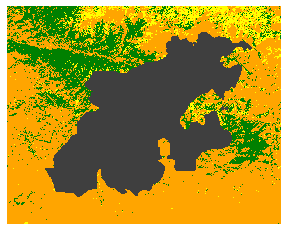

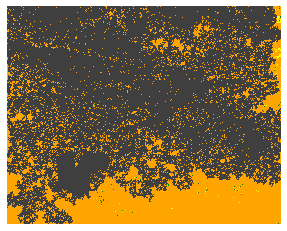

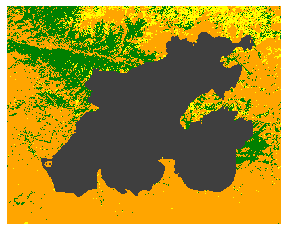

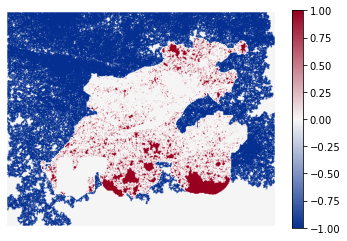

In [24]:
for fire_index in fire_index_list:
    fire_name = fire_list[fire_index]
    # Load Fire info
    with open(f"./CA/data/{fire_index}_info_{fire_name}.json", 'r') as load_f:
        fire_info = json.load(load_f)
    
    # Load Runtime
    with open(f"./CA/result/time/{fire_index}_time_{fire_name}.json", 'r') as load_f:
        ca_runtime = json.load(load_f)['runtime']

    # Read Forest
    forest = Image.open(f'./CA/data/{fire_index}_canopy_{fire_name}.tif')
    forest = np.array(forest)
    forest[forest < -999.] = 0.
    forest = forest/np.max(forest)

    # Read CA predict fire
    ca_pred = np.load(f"./CA/result/{fire_index}_fire_range_{fire_name}_{fire_info['total_day']}.npy", 'r')
    ca_pred_binary = convert_forest_array_to_binary(ca_pred)
    
    # Read turth_fire
    truth_binary = read_ignition_to_binary(f'./CA/data/{fire_index}_ignition_{fire_name}_final.png',(forest.shape[1], forest.shape[0]))
    day2_binary = read_ignition_to_binary(f'./CA/data/{fire_index}_ignition_{fire_name}_2.png',(forest.shape[1], forest.shape[0]))
    
    error_ca = truth_binary - ca_pred_binary
    
    print(fire_info)
    
    day2_forest_array = convert_binary_to_forest_array(day2_binary) 
    plt.imshow(forest + day2_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/ca/{fire_index}_{fire_name}_day2.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()

    ca_forest_array = convert_binary_to_forest_array(ca_pred_binary)
    plt.imshow(forest + ca_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/ca/{fire_index}_{fire_name}_predict.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()

    truth_forest_array = convert_binary_to_forest_array(truth_binary)
    plt.imshow(forest + truth_forest_array, cmap=cmap, norm=norm,
                   interpolation="none", vmin=0., vmax=4.)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/ca/{fire_index}_{fire_name}_truth.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    plt.show()
    plt.close()

#     plt.imshow(ca_pred_binary)
#     plt.colorbar()
#     plt.show()
#     plt.close()
    
#     plt.imshow(truth_binary)
#     plt.colorbar()
#     plt.show()
#     plt.close()

    clist=['#053091','#f7f6f6','#97001f']
    newcmp = LinearSegmentedColormap.from_list('error',clist)
    plt.imshow(error_ca,cmap=newcmp)
    plt.axis('off')
    plt.savefig(
            f'./benchmark-result/ca/{fire_index}_{fire_name}_error.png', 
            format='png', bbox_inches='tight',pad_inches = 0)
    
    plt.colorbar()
    plt.show()
    plt.close()